# Data, Setup, Import

To run the code, simply place the CSV file in the same folder as this notebook.

In [1]:
# Set project root
import os
root = os.getcwd()

# Import libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

In [2]:
# Import data
data = pd.read_csv(os.path.join(root, "data_election_articles_final.csv"))
data = data.drop_duplicates()
data.head()

,title,bias,article,content,topic
0,US Interest On Debt Reaches All-Time High,right,Federal deficit nears $2 trillion and getting ...,Federal deficit nears $2 trillion and getting ...,Election
1,US Interest On Debt Reaches All-Time High,center,US budget deficit tops $1.8 trillion in fiscal...,US budget deficit tops $1.8 trillion in fiscal...,Election
2,US Interest On Debt Reaches All-Time High,left,"US Posts $1.8 Trillion Annual Deficit, Highest...","US Posts $1.8 Trillion Annual Deficit, Highest...",Election
3,What Will Trump Do With the Department of Educ...,right,Trump plans to shift school funding control to...,Trump plans to shift school funding control to...,Election
4,What Will Trump Do With the Department of Educ...,left,Could Trump Shut Down the Department of Educat...,Could Trump Shut Down the Department of Educat...,Election


The dataset for this analysis was gathered by scraping **AllSides.com**, which aggregates news articles labeled by bias. 
We used a scraping script **inspired from (Haak et al 2023)**. This script uses selenium and chrome driver to simulate a web activity en scrape dynamic data from allsides.com

The articles for left, right and center were collected on the same allsides article. Meaning, all article in the corpus treats about the same subjects.


Specifically, for each topic related to the **2024 U.S. presidential election**, AllSides displays news headlines from:
- Left-biased sources,
- Right-biased sources, and
- Center-biased sources (when available).

We collected:
- The main title allocated by AllSides for each article (often describing the topic).
- The bias label (left, right, or center)
- The headline from the newspaper itself
- The first few paragraphs of each article (the primary content for textual analysis).


In [3]:
# Data shape and number of article per bias
data.shape, data['bias'].value_counts()

((1245, 5),
 bias
 left      434
 right     429
 center    382
 Name: count, dtype: int64)

# Data Exploration

First, let's check if the data have any missing values.

Due to how the data was collected, it should not contain too many missing rows.

In [4]:
# Check for null values
for col, val in zip(data.columns, data.isnull().sum()):
    if val > 0:
        print(f"{val} null Values were found in column {col}.")
        
# Drop null values
data = data.dropna()

1 null Values were found in column content.


Now, let's investigate the length of the texts (characters).

We do this for :
- Detection of text that is too short for analysis (<5 characters)
- Detection of text that is too long : the goal is to avoid overflow during text processing. (This is why do it before text processing)

<Axes: >

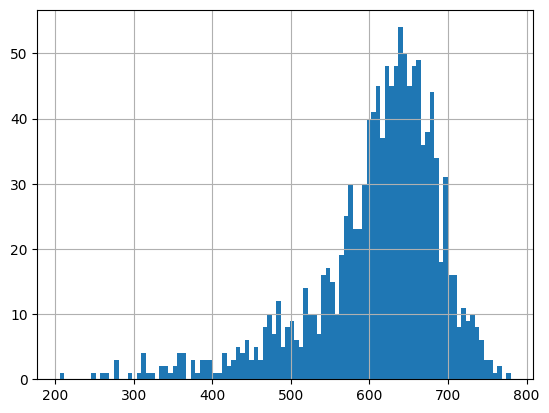

In [6]:
# Distribution of text length (character wise)
data['content_char_len'] = data['content'].apply(len)
# Plot distribution
data['content_char_len'].hist(bins=100)

From the histogram, we can conclude that :
- There is no article with more than ~770 characters
- There is no article with less than 10 characters

Therefore, we can **safely proceed to the text processing steps**.

# Cleaning and tokenization

As a first layer of preprocessing, let's apply basic text cleaning steps.

Considering the nature and source of our data (web scrapped news article), some additionnal steps are added :
- Removing external URLs and links
- Removing any HTML tags or component (due to scrapping error)

In [7]:
import re

def clean_news_article_text(text: str) -> str:
    """
    Cleans the input text (news article) by applying several preprocessing steps.
    """

    # Remove URLs (e.g., "https://...")
    # Explanation: Many news articles include links. 
    text = re.sub(r'http\S+', '', text)  
    
    # 2) Remove HTML tags (e.g., <p>, <br>, etc.) if any are present
    text = re.sub(r'<.*?>', '', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)

    # 4) Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace (more than one space)
    text = re.sub(r'\s+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    # Strip leading and trailing whitespace
    text = text.strip()

    return text

In [8]:
# Apply cleaning to the content
data["cleaned_text"] = data["content"].apply(clean_news_article_text)

After cleaning the text, we need to tokenize it.

Let's use **NLTK word_tokenize** function for that.

In [9]:
def tokenize(text: str) -> list:
    return word_tokenize(text)

In [10]:
# Apply tokenization
data["tokens"] = data["cleaned_text"].apply(tokenize)

# Check data types of results
print(type(data["tokens"].iloc[0]))

<class 'list'>


In [11]:
# Visualise data just to check
data[["cleaned_text", "tokens"]].head()

,cleaned_text,tokens
0,federal deficit nears trillion and getting wor...,"[federal, deficit, nears, trillion, and, getti..."
1,us budget deficit tops trillion in fiscal thir...,"[us, budget, deficit, tops, trillion, in, fisc..."
2,us posts trillion annual deficit highest outsi...,"[us, posts, trillion, annual, deficit, highest..."
3,trump plans to shift school funding control to...,"[trump, plans, to, shift, school, funding, con..."
4,could trump shut down the department of educat...,"[could, trump, shut, down, the, department, of..."


Tokenization is a success. We can now jump to more complex preprocessing.

# Text preprocessing

The text processing will mainly consist of lemmatization.

In order to perform lemmatization, we need to compute POS-tagging beforehand.

In [12]:
# Functiont to apply POS-tagging to tokens
def pos_tag_tokens(tokens: list[str]) -> list[tuple[str, str]]:
    return nltk.pos_tag(tokens)

# Apply POS-tagging
data["pos_tags"] = data["tokens"].apply(pos_tag_tokens)

# Visual check
data[["tokens", "pos_tags"]].head()

,tokens,pos_tags
0,"[federal, deficit, nears, trillion, and, getti...","[(federal, JJ), (deficit, NN), (nears, VBZ), (..."
1,"[us, budget, deficit, tops, trillion, in, fisc...","[(us, PRP), (budget, NN), (deficit, NN), (tops..."
2,"[us, posts, trillion, annual, deficit, highest...","[(us, PRP), (posts, VBZ), (trillion, CD), (ann..."
3,"[trump, plans, to, shift, school, funding, con...","[(trump, NN), (plans, NNS), (to, TO), (shift, ..."
4,"[could, trump, shut, down, the, department, of...","[(could, MD), (trump, VB), (shut, VB), (down, ..."


Notes :
- Lemmatization is applied on POS tagged text

In [13]:
# LEMMATIZATION

# Function to convert wordnet POS tags to wordnet lemmatizer POS tags
def get_wordnet_pos(treebank_tag: str) -> str:
    """
    Map the Penn Treebank POS tags to the format WordNetLemmatizer expects:
    'n' for nouns, 'v' for verbs, 'a' for adjectives, 'r' for adverbs.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Apply lemmatization on part-of-speech tagged tokens
def lemma(pos_tagged_tokens: list[tuple[str, str]], lemmatizer: WordNetLemmatizer) -> list[str]:
    """
    Lemmatizes the given list of (token, POS) tuples using their POS tags for improved accuracy.
    """

    lemmatized_tokens = []
    for word, pos in pos_tagged_tokens:
        # Convert Penn Treebank tag to a WordNet tag
        wn_pos = get_wordnet_pos(pos)
        # Lemmatize the word using the appropriate POS
        lemmatized_word = lemmatizer.lemmatize(word, pos=wn_pos)
        lemmatized_tokens.append(lemmatized_word)

    return lemmatized_tokens

In [14]:
# Apply lemmatization
data["lemmas"] = data["pos_tags"].apply(lemma, lemmatizer=WordNetLemmatizer())

# Visual check
data[["tokens", "lemmas"]].head()

,tokens,lemmas
0,"[federal, deficit, nears, trillion, and, getti...","[federal, deficit, near, trillion, and, get, b..."
1,"[us, budget, deficit, tops, trillion, in, fisc...","[u, budget, deficit, top, trillion, in, fiscal..."
2,"[us, posts, trillion, annual, deficit, highest...","[u, post, trillion, annual, deficit, high, out..."
3,"[trump, plans, to, shift, school, funding, con...","[trump, plan, to, shift, school, fund, control..."
4,"[could, trump, shut, down, the, department, of...","[could, trump, shut, down, the, department, of..."


Now that we applied lemmatization, we can remove stopwords.

The stopwords does not add any useful informations to our text.

In [15]:
def remove_stopwords(tokens: list, language: str = 'english') -> str:
    """
    Removes stopwords from the given tokenized text
    """

    # Load the stopwords for the specified language
    stop_words = set(stopwords.words(language))

    # Filter out stopwords
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [16]:
# Remove stopwords
data["lemmas"] = data["lemmas"].apply(remove_stopwords)

# Visual check
data[["tokens", "lemmas"]].head()

,tokens,lemmas
0,"[federal, deficit, nears, trillion, and, getti...","[federal, deficit, near, trillion, get, bad, e..."
1,"[us, budget, deficit, tops, trillion, in, fisc...","[u, budget, deficit, top, trillion, fiscal, th..."
2,"[us, posts, trillion, annual, deficit, highest...","[u, post, trillion, annual, deficit, high, out..."
3,"[trump, plans, to, shift, school, funding, con...","[trump, plan, shift, school, fund, control, lo..."
4,"[could, trump, shut, down, the, department, of...","[could, trump, shut, department, education, ca..."


# Word frequency

We use the nltk library to compute the word frequency for the lemmatized text.

From previous work on the same dataset, we know it is not useful to try word frequency on the data if stop words are not removed.

Also, stemming does not work well for this dataset with very news-specific langage.

For better visualisation, we will barplot the results.

In [17]:
# Function to compute word frequency
def compute_word_frequency(docs: list[list[str]]) -> nltk.probability.FreqDist:
    """
    Computes the word frequency for a corpus of tokenized documents using NLTK's FreqDist.
    """
    # Flatten all documents into one list of tokens
    all_tokens = [token for doc in docs for token in doc]

    # Use FreqDist to compute word frequencies
    freq_dist = nltk.probability.FreqDist(all_tokens)

    return freq_dist

In [18]:
# Compute word frequency on lemmatized text
lemmatized_text_frequency = compute_word_frequency(data["lemmas"])

In [19]:
# Function to plot the most common words
def plot_word_frequencies(word_freq: nltk.probability.FreqDist,
                          top_n: int = 20, 
                          title: str = "Top Words by Frequency",
                          color: str = "dark:darkred") -> None:
    """
    Plots a horizontal bar chart of the top_n most frequent words using seaborn.

    :param word_freq: A dictionary {word: freq} or an NLTK FreqDist object.
    :param top_n: Number of top words to display in the plot.
    :param title: Title for the plot.
    """

    # If word_freq is a FreqDist, convert it to dict
    if isinstance(word_freq, nltk.probability.FreqDist):
        word_freq = dict(word_freq)

    # Sort by frequency (descending order)
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

    words = [item[0] for item in sorted_word_freq]
    freqs = [item[1] for item in sorted_word_freq]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words, hue=words, palette=color, legend=False)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(title)
    plt.tight_layout()
    plt.show();

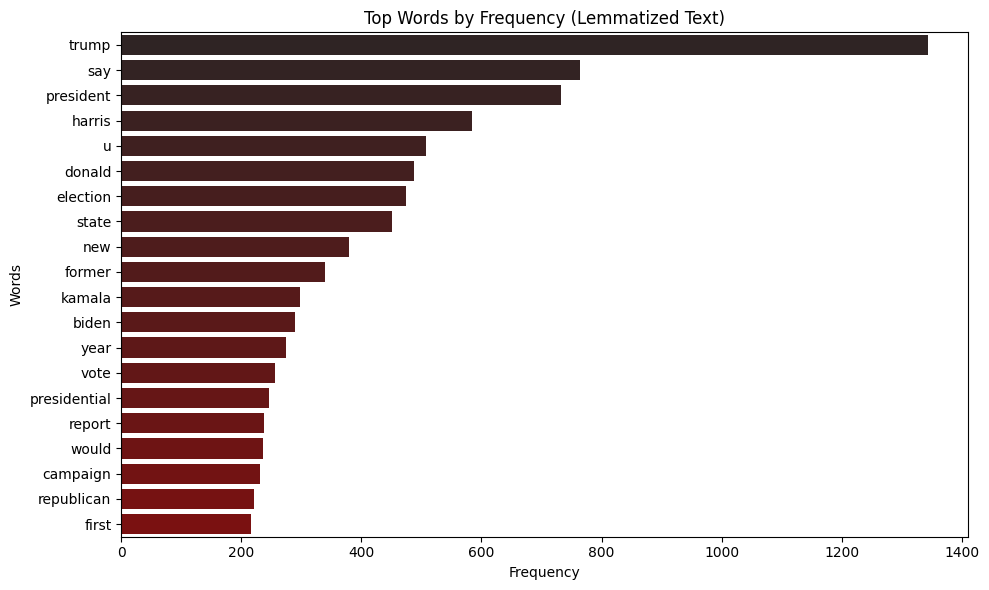

In [20]:
plot_word_frequencies(lemmatized_text_frequency, title="Top Words by Frequency (Lemmatized Text)")

We can now visualise this with a wordcloud plot.

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk


# Function to plot a word cloud given a frequency distribution
def plot_wordcloud(word_freq: nltk.probability.FreqDist, 
                   title: str = "Word Cloud",
                   max_words: int = 200,
                   background_color: str = "white",
                   colormap: str = "dark:darkred",
                   min_font_size: int = 10,
                   max_font_size: int = 100,
                   font_step: int = 1,
                   contour_width: float = 0.0,
                   contour_color: str = "black",
                   font_path: str = None) -> None:
    """
    Generates and plots a word cloud from either a dictionary {word: freq}
    or an NLTK FreqDist object, using the wordcloud library.
    
    Params:
        word_freq: A dictionary of {word: frequency} or an NLTK FreqDist object.
        title: Title for the plotted word cloud image.
        max_words: Maximum number of words to display in the word cloud.
        background_color: Background color for the word cloud image.
        colormap: Colormap for coloring the words (default is "viridis") ["Reds", "seismic", "Blues"].
        min_font_size: Minimum font size for the smallest word.
        max_font_size: Maximum font size for the largest word.
        font_step: Step size for the font. 1 means try every size from min to max.
        contour_width: Outline width around each word (set to 0 for no outline).
        contour_color: Outline color around words if contour_width > 0.
        font_path: Path to a specific .ttf/.otf font file if you want to override.
    """

    # If word_freq is an NLTK FreqDist, convert it to a dict
    if isinstance(word_freq, nltk.probability.FreqDist):
        word_freq = dict(word_freq)

    # Create the WordCloud object
    wc = WordCloud(
        width=800,
        height=400,
        max_words=max_words,
        background_color=background_color,
        colormap=colormap,
        min_font_size=min_font_size,
        max_font_size=max_font_size,
        font_step=font_step,
        contour_width=contour_width,
        contour_color=contour_color,
        font_path=font_path 
    )

    # Generate the word cloud from frequencies
    wc.generate_from_frequencies(word_freq)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")  # Hide the axis
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show();


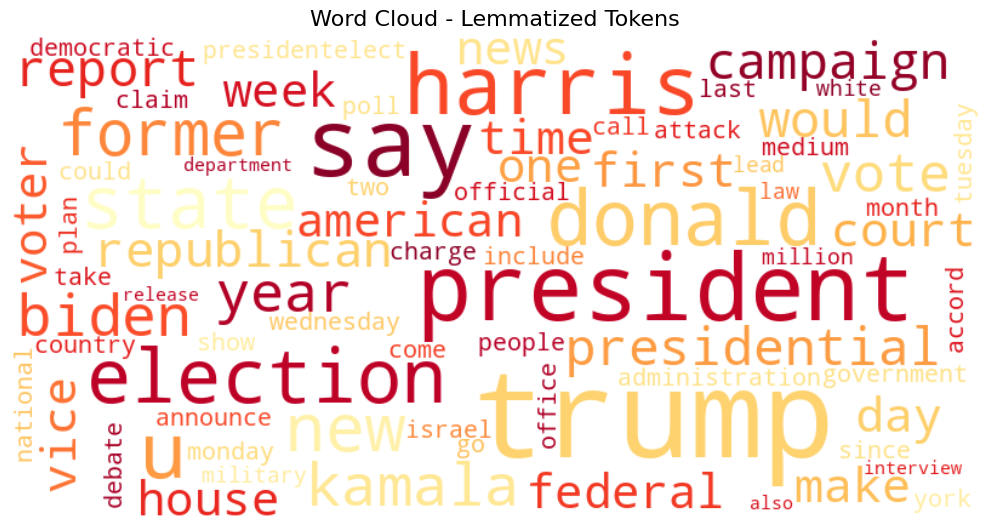

In [22]:
# Plot the word cloud
plot_wordcloud(lemmatized_text_frequency,
               title="Word Cloud - Lemmatized Tokens",
               max_words=75,
               background_color="white",
               colormap="YlOrRd_r",
               min_font_size=10,
               max_font_size=100,
               font_step=1,
               contour_width=0.5,
               contour_color="black",
               )

From this first wordcloud, we can see expected results :
- the most frequent words are : Trump, Election, President, Biden and other election-related words.
- We cannot pull meaningful insights from this wordcloud for now.

## Word Frequency : Left vs Right vs Center bias

Let's try to investigate the difference in news coverage between left-biased and right-biased newspapers, as well as center biased newspaper for benchmark.

First, let's explore our data to see if any data transformation is needed to make left and right comparable.

In [23]:
# Count number of articles per bias
data['bias'].value_counts()

bias
left      434
right     428
center    382
Name: count, dtype: int64

We see that there are approximately the same number of articles for left and right bias.

Now, let's investigate the titles of the articles.

In [24]:
# Count unique values in the 'title column' for each bias
data.groupby('bias')['title'].nunique()

bias
center    382
left      434
right     428
Name: title, dtype: int64

In [25]:
# Compare titles per bias 
right_titles = data[data['bias'] == 'right']['title']
left_titles = data[data['bias'] == 'left']['title']

# Check how many titles are shared between the two groups
shared_titles = set(right_titles).intersection(set(left_titles))
len(shared_titles)

425

From this result and knowing the dataset structure, we can conclude that the articles are fairly comparable between right and left bias.

Now, let's investigate word frequency for right-biased and left-biased articles.

In [26]:
# Compute word frequency for both groups
right_word_freq = compute_word_frequency(data[data["bias"] == "right"]["lemmas"])
left_word_freq = compute_word_frequency(data[data["bias"] == "left"]["lemmas"])

In [27]:
# Compare top words by frequency
def plot_left_right_top_words(left_freqdist: nltk.probability.FreqDist,
                              right_freqdist: nltk.probability.FreqDist,
                              top_n: int = 15,
                              n_grams: bool = False) -> None:
    """
    Plots a grouped bar chart comparing the top words (by frequency) 
    from 'left' vs. 'right'. Words that appear only in one side's top N 
    are plotted with a frequency of 0 for the other side.
    
    :param left_freqdist: NLTK FreqDist for the 'left' subset.
    """
    # Overall freqdist
    overall_freqdist = left_freqdist + right_freqdist
    top_overall = overall_freqdist.most_common(top_n)
    
    
    top_overall_dict = {}
    for word_or_ngram, freq in top_overall:
        if n_grams:
            # Join n-gram tuple into a single string
            if isinstance(word_or_ngram, tuple):
                word_str = "_".join(word_or_ngram)
            else:
                word_str = word_or_ngram
            top_overall_dict[word_str] = freq
        else:
            # Keep as is (already a string for single words)
            top_overall_dict[word_or_ngram] = freq
            
            
    combined_freqs = {}
    for word_str, overall_freq in top_overall_dict.items():
        # We need to check the original left/right freqdist
        # But note if n_grams=True, we have to re-join the tuple to look it up
        if n_grams:
            # To look up in freqdist, we must revert to the original tuple form
            # Or we do a small helper if we stored them differently
            # We'll do the reverse split -> tuple approach
            original_ngram = tuple(word_str.split("_"))
            freq_left = left_freqdist[original_ngram]
            freq_right = right_freqdist[original_ngram]
        else:
            freq_left = left_freqdist[word_str]
            freq_right = right_freqdist[word_str]

        combined_freqs[word_str] = {
            "left": freq_left,
            "right": freq_right
        }

    # 4) Convert to a DataFrame: word | left | right
    rows = []
    for word, lr_dict in combined_freqs.items():
        rows.append((word, lr_dict["left"], lr_dict["right"]))
    df = pd.DataFrame(rows, columns=["word", "left", "right"])

    # 5) Sort by the max frequency so the biggest bars appear first
    df["max_freq"] = df[["left", "right"]].max(axis=1)
    df = df.sort_values("max_freq", ascending=False).drop(columns="max_freq")

    # 6) Melt to long format for Seaborn
    df_melted = df.melt(
        id_vars="word", 
        var_name="bias", 
        value_name="frequency"
    )

    # 7) Plot
    plt.figure(figsize=(10, 6))
    palette = {"left": "navy", "right": "darkred"}
    sns.barplot(
        data=df_melted,
        x="word",
        y="frequency",
        hue="bias",
        palette=palette
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top {top_n} Words (Overall) - Left vs. Right Coverage")
    plt.tight_layout()
    plt.show()

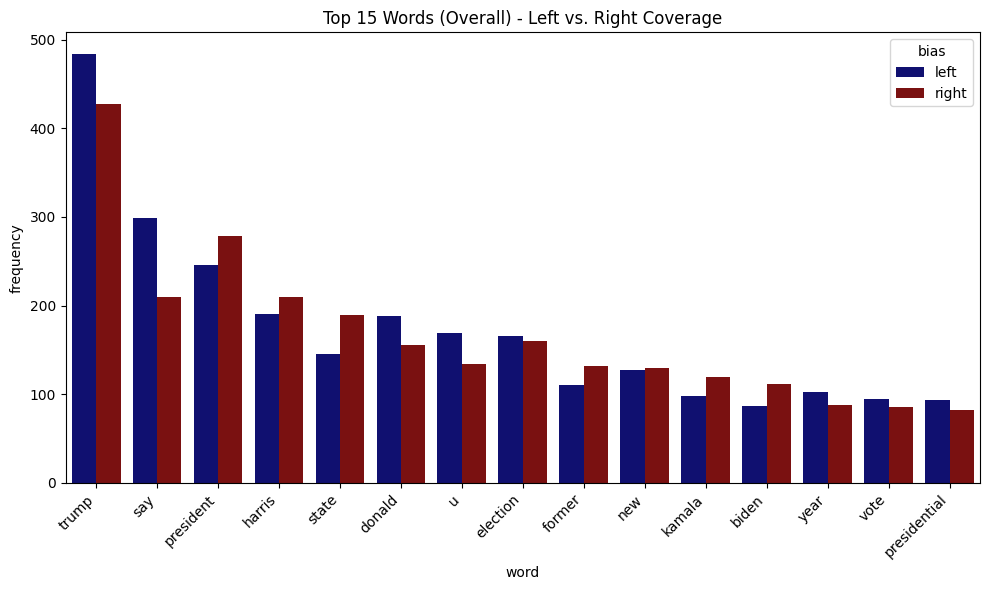

In [28]:
# 1) Split by bias and compute FreqDist
left_corpus = data[data["bias"] == "left"]["lemmas"].tolist()
right_corpus = data[data["bias"] == "right"]["lemmas"].tolist()


# Flatten tokens into a single list for each bias
left_tokens = [token for doc in left_corpus for token in doc]
right_tokens = [token for doc in right_corpus for token in doc]

left_freqdist = nltk.probability.FreqDist(left_tokens)
right_freqdist = nltk.probability.FreqDist(right_tokens)

# 2) Plot
plot_left_right_top_words(left_freqdist, right_freqdist, top_n=15)

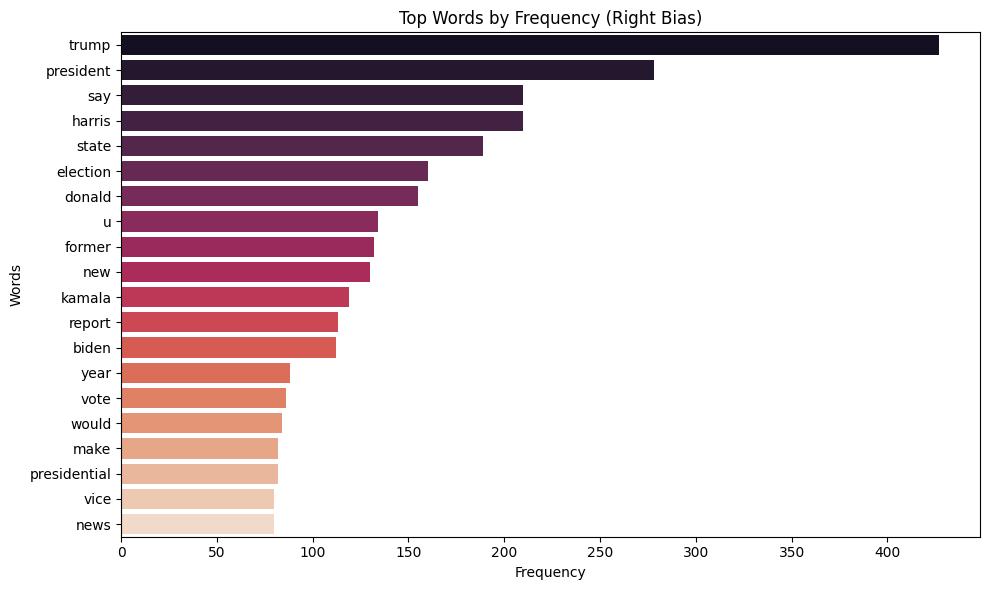

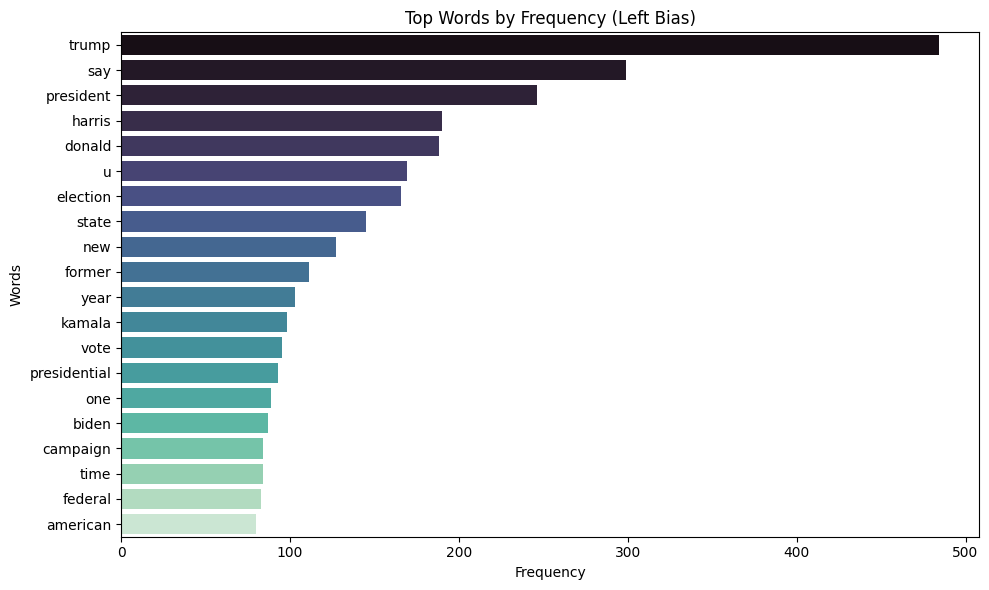

In [28]:
# Plot the word frequency
plot_word_frequencies(right_word_freq, title="Top Words by Frequency (Right Bias)", color="rocket")
plot_word_frequencies(left_word_freq, title="Top Words by Frequency (Left Bias)", color="mako")

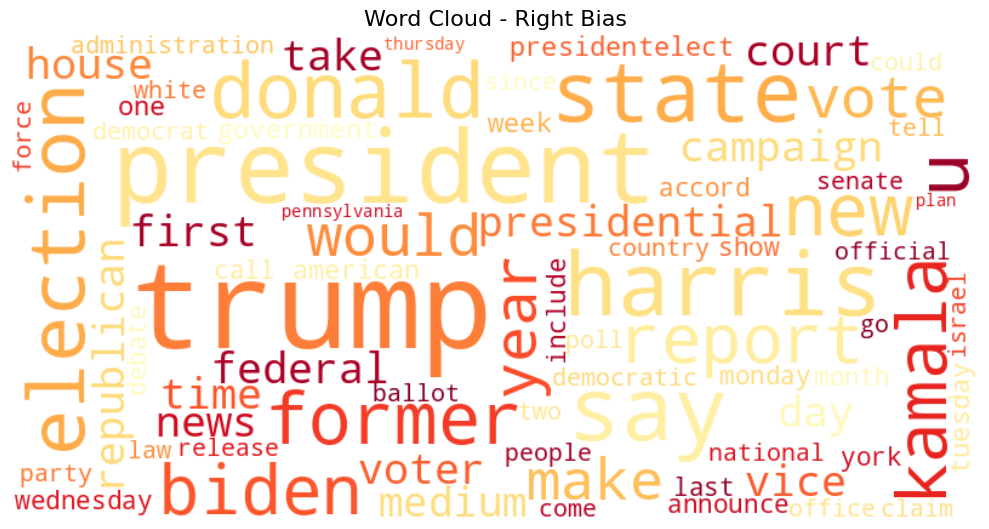

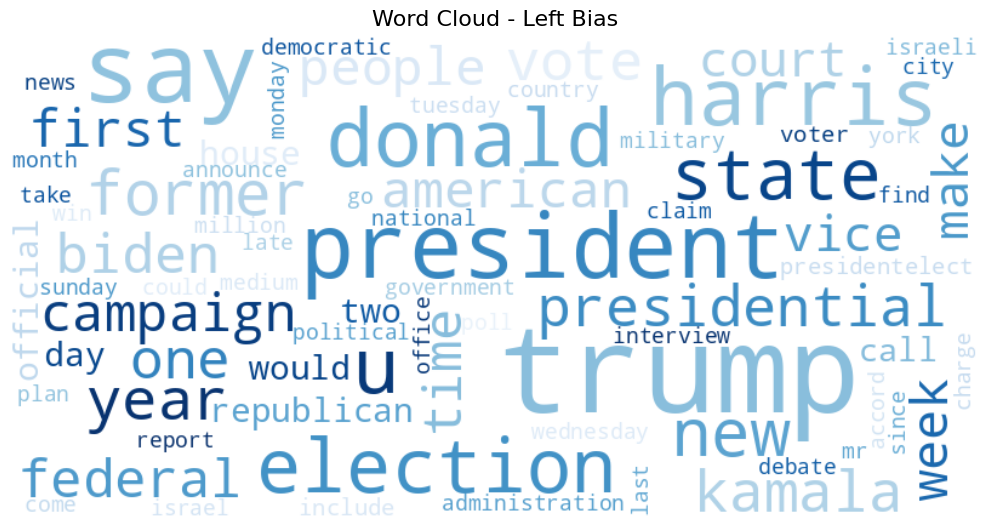

In [29]:
# Plot the wordclouds
plot_wordcloud(right_word_freq, title="Word Cloud - Right Bias", max_words=75, colormap="YlOrRd_r")
plot_wordcloud(left_word_freq, title="Word Cloud - Left Bias", max_words=75, colormap="Blues_r")

From this analysis and these plots, we can conclude multiple things :
- Both rights and left have the same common words (candidates names, politial keywords...)
- It would be useful to deepen the analysis with n-grams analysis and by removing named entities.

## Bi-Gram and Tri-Gram analysis

To conduct our analysis further, we will try the same techniques as before on bi-grams and tri-grams.

This way, we hope to identify differentiation patterns between left and right.

In [30]:
# Import useful packages
from nltk.util import bigrams, trigrams

# Build bigrams and trigrams on lemmatized text
data["bigrams"] = data["lemmas"].apply(lambda x: list(bigrams(x)))
data["trigrams"] = data["lemmas"].apply(lambda x: list(trigrams(x)))

# Compute frequency distribution for bigrams and trigrams per bias
left_bigrams_freq = compute_word_frequency(data[data["bias"] == "left"]["bigrams"])
right_bigrams_freq = compute_word_frequency(data[data["bias"] == "right"]["bigrams"])

left_trigrams_freq = compute_word_frequency(data[data["bias"] == "left"]["trigrams"])
right_trigrams_freq = compute_word_frequency(data[data["bias"] == "right"]["trigrams"])

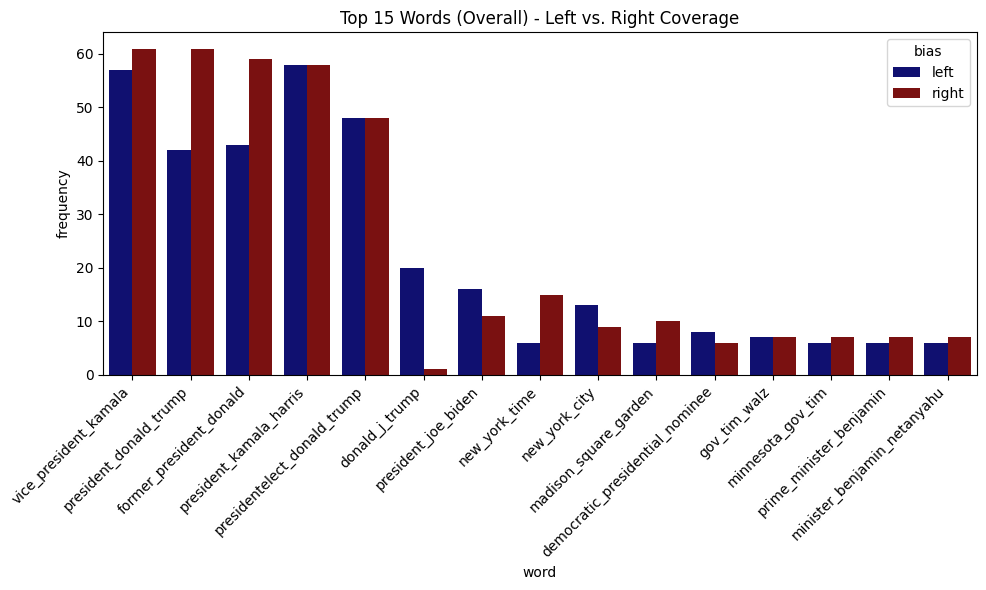

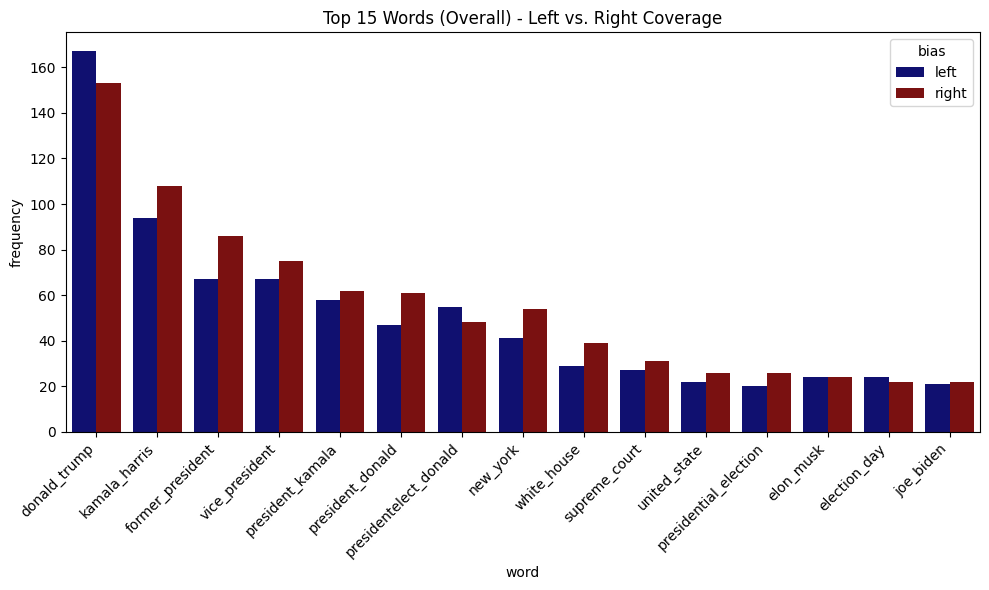

In [32]:
# Plot bigrams frequency left vs right
plot_left_right_top_words(left_trigrams_freq, right_trigrams_freq, top_n=15, n_grams=True)
plot_left_right_top_words(left_bigrams_freq, right_bigrams_freq, top_n=15, n_grams=True)

As we could have expected, as the corpus is focusing on news article covering the 2024 election period, the candidates names and politicians names are among the most frequent in the text.

However, from the tri-gram plot, we can see some interesting facts :
- The right calls Trump "Former President" and "President" way more than the left
- The left calls Trump "Donald J. Trump" while the right never call him that

## Name Entity Recognition (NER)

Let's try Name Entity Recognition to **delete the names from the corpus** in order to extract more meaningful text.

We use the SpaCy library to perform NER.

SpaCy's NER uses a CNN-based model with transition-based parsing. It tokenizes text, extracts word/character features, and applies a BiLSTM (or transformer) to predict entity labels.


In [31]:
import spacy

# Load the small English model
nlp = spacy.load("en_core_web_sm")

# Function to extract and remove named entities
def remove_named_entities(text: list[str]) -> list[str]:
    """
    Removes named entities from the given list of tokens.
    """
    # Join the tokens back into a single string
    text = " ".join(text)
    
    # Apply the NER model
    doc = nlp(text)
    
    # Remove named entities from the text
    tokens_without_ents = []
    for token in doc:
        if token.ent_iob_ == "O":
            tokens_without_ents.append(token.text)
            
    return tokens_without_ents

# Hardcoded list of named entities
NAMED_ENTITIES = ["joe", "biden", "donald", "trump", "kamala", "harris", "mike", "pence", "president", "fox", "journal"]

# Apply spacy NER and remove named entities
data["no_named_entities"] = data["lemmas"].apply(remove_named_entities)

# Remove hardcoded named entities
data["no_named_entities"] = [list(filter(lambda x: x not in NAMED_ENTITIES, tokens)) for tokens in data["no_named_entities"]]

Now let's try word frequency and plot again.

In [32]:
# Build bigrams and trigrams
data["bigrams_no_ne"] = data["no_named_entities"].apply(lambda x: list(bigrams(x)))
data["trigrams_no_ne"] = data["no_named_entities"].apply(lambda x: list(trigrams(x)))

# Compute frequency distribution for bigrams and trigrams per bias
left_bigrams_freq_none = compute_word_frequency(data[data["bias"] == "left"]["bigrams_no_ne"])
right_bigrams_freq_none = compute_word_frequency(data[data["bias"] == "right"]["bigrams_no_ne"])

left_trigrams_freq_none = compute_word_frequency(data[data["bias"] == "left"]["trigrams_no_ne"])
right_trigrams_freq_none = compute_word_frequency(data[data["bias"] == "right"]["trigrams_no_ne"])

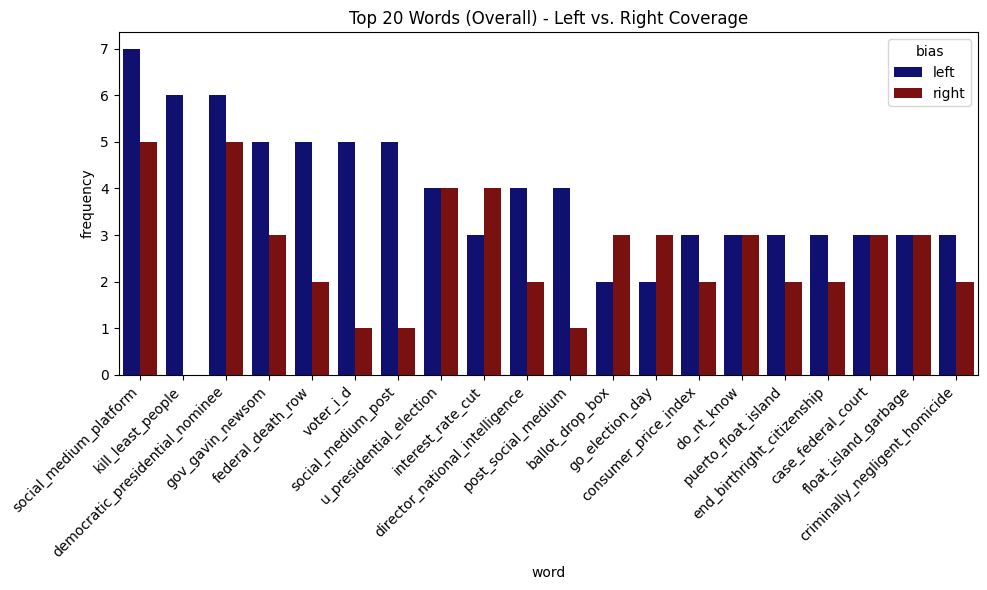

In [33]:
# Plot bigrams frequency left vs right
plot_left_right_top_words(left_trigrams_freq_none, right_trigrams_freq_none, top_n=20, n_grams=True)

From this plot we can see some interesting results :
- **interest_rate_cut** is mentioned more often by the right
- **go_election_day** is mentioned more often by the right
- **consumer price index** is mentioned more often by the left

##### Bert-based Name Entity Recognition

In order to improve our NER, we will try using a BERT-based model that is way more accurate and powerful.

The model is pre-trained to perfom NER on raw text.

Therefore, we will create a copy of the data, taking only the raw text, and we will re-perform text cleaning for analysis after that.

In [34]:
# Initialize NER model

# Import NER pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Instantiate tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# Load the NER pipeline
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


Now, we define a function that :
- Perform NER on the raw text
- Remove identified persons using the model output
- Return both the model output (text without entities)

In [35]:
# Define a function to remove named entities with BERT-based model
def remove_entities(text):
    """
    Removes named entities of type 'PERSON' and 'LOCATION' from the input text based on NER model output.
    
    :param text: str, the original raw text
    :return: str, cleaned text with person names and locations removed
    """
    
    # Compute NER on input text
    ner_output = nlp_ner(text)  # Assuming nlp_ner is your NER model function
    
    # Identify character spans to remove
    remove_spans = []
    current_span = None

    for entity in ner_output:
        if entity["entity"].startswith(("B-PER", "B-LOC")):  # Start of a new person or location name
            if current_span:  # If a previous span exists, add it to remove_spans
                remove_spans.append(current_span)
            current_span = [entity["start"], entity["end"]]  # New span starts
        elif entity["entity"].startswith(("I-PER", "I-LOC")) and current_span:
            # Extend current span if part of the same named entity
            current_span[1] = entity["end"]

    # Add last detected span
    if current_span:
        remove_spans.append(current_span)

    # Remove detected spans from text
    cleaned_text = text
    for start, end in reversed(remove_spans):  # Reverse to avoid shifting indices
        cleaned_text = cleaned_text[:start] + cleaned_text[end:]

    # Normalize spaces after removal
    cleaned_text = " ".join(cleaned_text.split())

    return cleaned_text

In [36]:
data["cleaned_text_no_persons"] = data["content"].apply(lambda x: remove_entities(x))

Now, we can perform the same preprocessing pipeline to the new text.

In [37]:
# Clean text
data["cleaned_text_no_persons"] = data["cleaned_text_no_persons"].apply(clean_news_article_text)

# Tokenize
data["tokens_no_persons"] = data["cleaned_text_no_persons"].apply(tokenize)

# Apply POS-tagging
data["pos_tags_no_persons"] = data["tokens_no_persons"].apply(pos_tag_tokens)

# Apply lemmatization
data["lemmas_no_persons"] = data["pos_tags_no_persons"].apply(lemma, lemmatizer=WordNetLemmatizer())

# Remove stopwords
data["lemmas_no_persons"] = data["lemmas_no_persons"].apply(remove_stopwords)

# Remove hardcoded words
WORDS = ["president", "election", 'say', "fox", "york"]
data["lemmas_no_persons"] = [list(filter(lambda x: x not in WORDS, tokens)) for tokens in data["lemmas_no_persons"]]

##### Word frequency analysis

Now, we can re-apply the same word frequency analysis on the new text.

In [38]:
# Build bigrams and trigrams
data["bigrams_no_ne"] = data["lemmas_no_persons"].apply(lambda x: list(bigrams(x)))
data["trigrams_no_ne"] = data["lemmas_no_persons"].apply(lambda x: list(trigrams(x)))

# Compute frequency distribution for bigrams and trigrams per bias
left_bigrams_freq_none = compute_word_frequency(data[data["bias"] == "left"]["bigrams_no_ne"])
right_bigrams_freq_none = compute_word_frequency(data[data["bias"] == "right"]["bigrams_no_ne"])

left_trigrams_freq_none = compute_word_frequency(data[data["bias"] == "left"]["trigrams_no_ne"])
right_trigrams_freq_none = compute_word_frequency(data[data["bias"] == "right"]["trigrams_no_ne"])

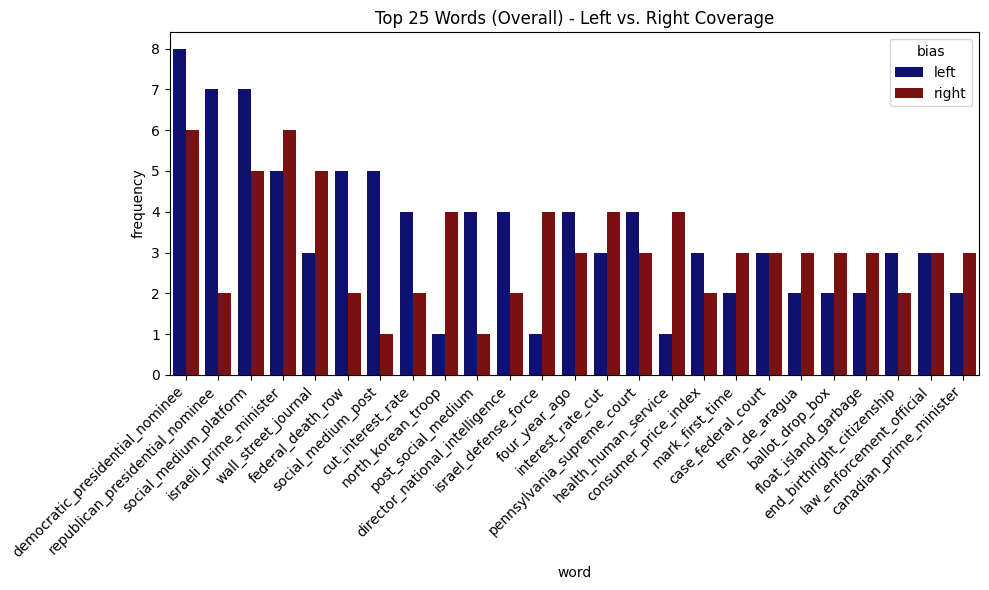

In [39]:
# Plot bigrams frequency left vs right
plot_left_right_top_words(left_trigrams_freq_none, right_trigrams_freq_none, top_n=25, n_grams=True)

# Topic Modeling

In order to perform topic modeling, we will proceed with the following steps :
- Convert the text to a Bag-of-Word model
- Train the LDA model and select the optimal number of topics
- Extract top words per topics and visualise topics

##### Build dictionnary and corpus

In [40]:
from gensim import corpora

def build_dictionary_and_corpus(df, column_name):
    """
    Build a Gensim dictionary and BoW corpus from a DataFrame column containing tokenized text.
    
    :param df: pandas DataFrame containing your data
    :param column_name: str, name of the column with tokenized text (e.g., 'lemmas_no_persons')
    :return: (dictionary, corpus)
        - dictionary: Gensim Dictionary object mapping word <-> id
        - corpus: list of lists of (token_id, token_count) for each document
    """
    # Extract tokenized text from the desired column
    tokenized_docs = df[column_name].tolist()
    
    # Build dictionary
    dictionary = corpora.Dictionary(tokenized_docs)
    
    # Convert tokenized docs to BoW corpus
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    
    return dictionary, corpus

In [41]:
# Build dictionary and corpus
dictionary, corpus = build_dictionary_and_corpus(data, "lemmas_no_persons")

# Check the dictionary and BoW corpus
print("Number of unique tokens:", len(dictionary))
print("First BoW entry:", corpus[0][:10])  # Show partial BoW for the first doc

Number of unique tokens: 7532
First BoW entry: [(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 6), (7, 1), (8, 1), (9, 1)]


##### Train LDA model

Now that we created our BoW model, we can perform topic modeling with the LDA model from gensim.

In [42]:
import gensim
from gensim.models.ldamodel import LdaModel

def run_lda(dictionary, corpus, num_topics=10, passes=10, random_state=42):
    """
    Train an LDA model using Gensim on the given corpus and dictionary.
    
    :param dictionary: Gensim Dictionary object
    :param corpus: list of (token_id, token_count) pairs
    :param num_topics: int, number of topics
    :param passes: int, number of passes (iterations over the corpus)
    :param random_state: int, for reproducibility
    :return: trained LdaModel object
    """
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state
    )
    return lda_model

In the next cell, we trained the LDA model. For reproducability purposes, please **load the provided LDA model.**

In [ ]:
# Train LDA Model
#lda_model = run_lda(dictionary, corpus, num_topics=5, passes=100)

# Load LDA model for reproducibility
# Place these files in a LDA directory with same level as this notebook
# lda_model
# lda_model.expElogbeta.npy
# lda_model.id2word
# lda_model.state
lda_model = LdaModel.load(os.path.join(root, "lda", "lda_model"))

# Print the top words in each of the 5 topics
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.007*"israeli" + 0.006*"military" + 0.005*"medium" + 0.005*"attack" + 0.004*"presidentelect"
Topic 1: 0.012*"year" + 0.010*"rate" + 0.007*"cut" + 0.006*"federal" + 0.006*"report"
Topic 2: 0.014*"vote" + 0.010*"former" + 0.009*"republican" + 0.009*"state" + 0.009*"voter"
Topic 3: 0.014*"state" + 0.013*"court" + 0.006*"judge" + 0.006*"ban" + 0.006*"would"
Topic 4: 0.012*"debate" + 0.008*"interview" + 0.008*"campaign" + 0.007*"former" + 0.007*"vice"


##### Get top topics for a single document

Now that we computed the topics using the LDA model, we can apply the model to our samples in order to retrieve the top 3 topic (probabilities) for each sample.

In [44]:
def get_top_topics_for_document(lda_model, bow_doc, top_n=3):
    """
    Given a trained LDA model and a single document in BoW format,
    return the top N topics (topic_id, probability).
    
    :param lda_model: trained Gensim LdaModel
    :param bow_doc: list of (token_id, token_count) for a single document
    :param top_n: int, number of top topics to return
    :return: list of (topic_id, topic_probability) sorted by probability descending
    """
    # Get topic distribution for the document
    topic_distribution = lda_model.get_document_topics(bow_doc)
    
    # Sort by probability (descending)
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    
    # Return the top N topics
    return sorted_topics[:top_n]

In [45]:
# Test our function on the first document
first_doc_bow = corpus[0]
top_topics_first_doc = get_top_topics_for_document(lda_model, first_doc_bow, top_n=3)
print("Top topics for first doc:", top_topics_first_doc)

Top topics for first doc: [(3, 0.6123465), (1, 0.37736407)]


##### Add LDA topics to dataframe

Now, we define a function to add the LDA topics as a column of our dataframe.

In [46]:
def add_lda_topics_to_dataframe(df, column_name, lda_model, dictionary, top_n=3, new_column_name="top_topics"):
    """
    Compute top N LDA topics for each document and add them to a new column in the DataFrame.
    
    :param df: pandas DataFrame
    :param column_name: str, name of the column with tokenized text (e.g. 'lemmas_no_persons')
    :param lda_model: trained Gensim LdaModel
    :param dictionary: Gensim Dictionary object
    :param top_n: int, number of top topics to return for each document
    :param new_column_name: str, name of the new column to be created
    :return: DataFrame with a new column containing the top topics for each document
    """
    # Create a copy to avoid modifying original DataFrame
    df = df.copy()
    
    # Initialize empty list to store topic info
    all_top_topics = []
    
    for tokens in df[column_name]:
        # Convert tokens to BoW
        bow_doc = dictionary.doc2bow(tokens)
        
        # Get top N topics
        topic_distribution = lda_model.get_document_topics(bow_doc)
        sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
        top_topics = sorted_topics[:top_n]
        
        # You could store them as a list of topic IDs, or (ID, prob), etc.
        # For interpretability, we store (topic_id, probability).
        all_top_topics.append(top_topics)
    
    # Assign to new column
    df[new_column_name] = all_top_topics
    return df

In [47]:
# Apply the function to create dataframe column
df_with_topics = add_lda_topics_to_dataframe(
    df=data,
    column_name="lemmas_no_persons",
    lda_model=lda_model,
    dictionary=dictionary,
    top_n=3,
    new_column_name="top_3_topics"
)

# Inspect the new DataFrame
df_with_topics[["lemmas_no_persons", "top_3_topics"]].head()

,lemmas_no_persons,top_3_topics
0,"[federal, deficit, near, trillion, get, bad, e...","[(3, 0.6122798), (1, 0.3774309)]"
1,"[budget, deficit, top, trillion, fiscal, third...","[(3, 0.85549176), (1, 0.1328184)]"
2,"[u, post, trillion, annual, deficit, high, out...","[(1, 0.5916516), (3, 0.39685547)]"
3,"[plan, shift, school, fund, control, local, co...","[(1, 0.66394675), (0, 0.325654)]"
4,"[could, shut, department, education, campaign,...","[(1, 0.8835005), (2, 0.10283103)]"


##### Visualise LDA

Now, we will visualise the topics and the top words per topic in order to define clusters.

In [48]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def visualize_lda(lda_model, corpus, dictionary):
    """
    Visualizes LDA topics using pyLDAvis.

    :param lda_model: Trained Gensim LdaModel
    :param corpus: BoW corpus
    :param dictionary: Gensim Dictionary
    :return: Displays the interactive visualization
    """
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return vis

# Example usage
lda_vis = visualize_lda(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)

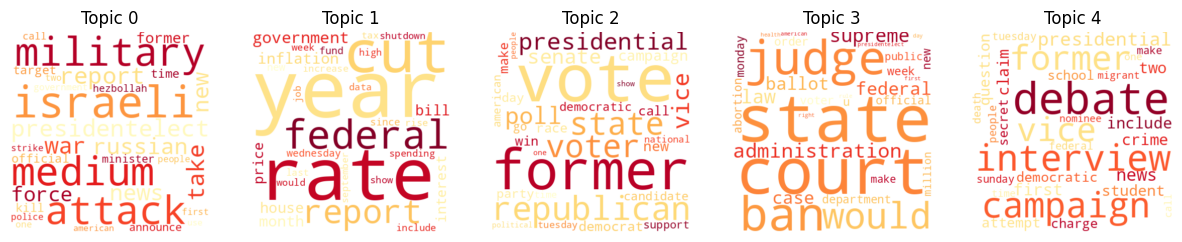

In [49]:
def plot_lda_wordclouds(lda_model, num_topics=5):
    """
    Plots word clouds for each topic.
    
    :param lda_model: Trained LdaModel
    :param num_topics: Number of topics to visualize
    """
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5))

    for i in range(num_topics):
        words = dict(lda_model.show_topic(i, topn=30))
        wordcloud = WordCloud(width=400, height=400, background_color="white", colormap="YlOrRd_r").generate_from_frequencies(words)
        
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(f"Topic {i}")

    plt.show()

# Example usage
plot_lda_wordclouds(lda_model, num_topics=5)

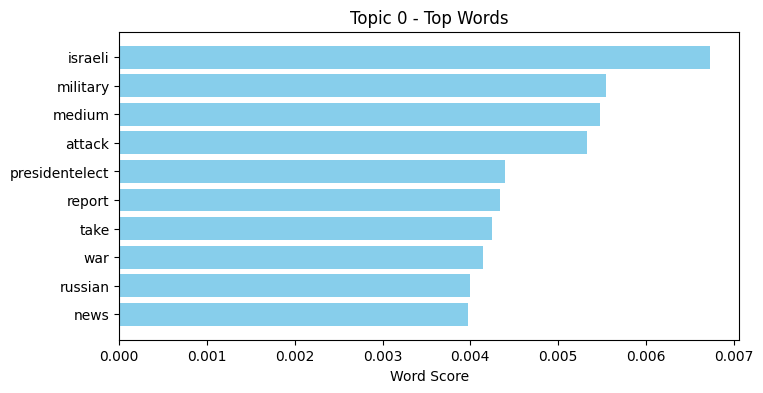

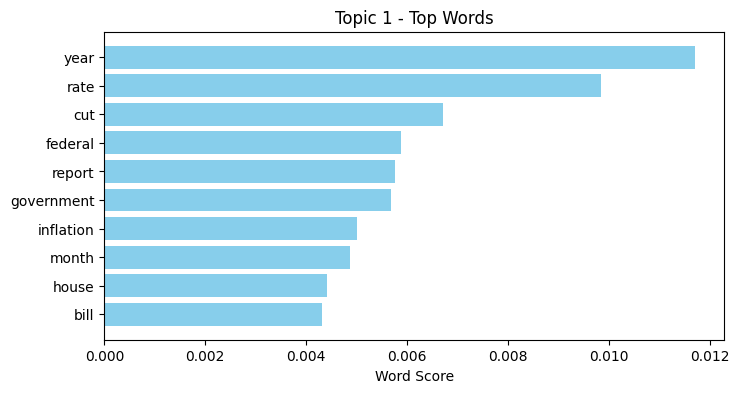

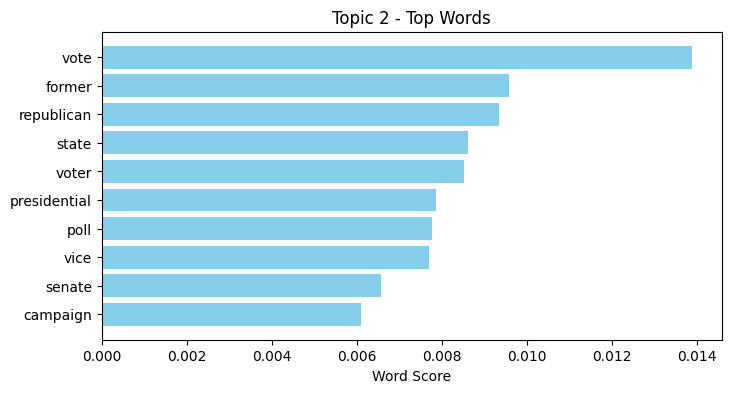

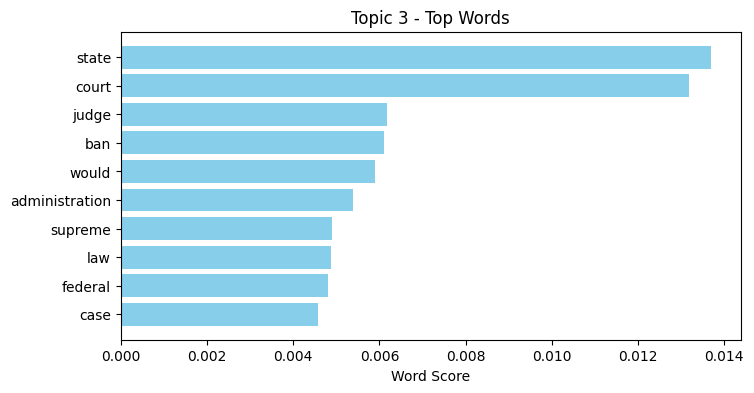

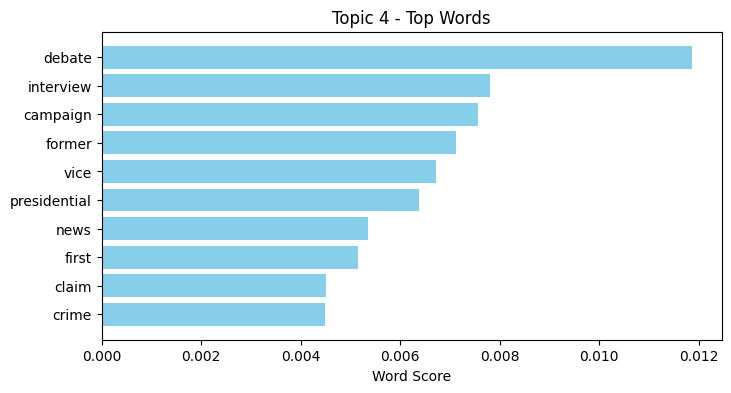

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_words_per_topic(lda_model, num_topics=5, num_words=10):
    """
    Plots bar charts of top words per topic.

    :param lda_model: Trained LdaModel
    :param num_topics: Number of topics to display
    :param num_words: Number of words per topic
    """
    for i in range(num_topics):
        words, scores = zip(*lda_model.show_topic(i, topn=num_words))
        plt.figure(figsize=(8, 4))
        plt.barh(words, scores, color="skyblue")
        plt.gca().invert_yaxis()
        plt.title(f"Topic {i} - Top Words")
        plt.xlabel("Word Score")
        plt.show()

# Example usage
plot_top_words_per_topic(lda_model, num_topics=5, num_words=10)

From the LDA topic modeling analysis, we can identify 4 clusters from the topics :
- Topic 0 : Foreign Policies (palestine-israel, hamas, russia...)
- Topic 1 : Economy
- Topic 2 : Election
- Topic 3 : Law & Politics
- Topic 4 : Domestic Policies

In [51]:
# Record topic modeling clusters in a dictionnary
topic_map = {
    0: "Foreign Policy",
    2: "Election",
    4: "Domestic Policy",
    1: "Economy",
    3: "Law and Politics"
}

In [54]:
# Save LDA model
#lda_model.save(os.path.join(root, "lda_model")

Let's investigate on the differences between right, left and center in the topic adressed.

In [52]:
from collections import defaultdict

def compute_bias_distribution_per_topic(df, topic_column="topic", bias_column="bias", num_topics=5):
    """
    Computes the proportion of articles with each bias (left, right, center) for each topic.

    :param df: pandas DataFrame containing the topic and bias columns
    :param topic_column: str, column name containing the list of top 3 topics [(topic_id, probability)]
    :param bias_column: str, column name containing the bias ("left", "right", "center")
    :param num_topics: int, total number of topics
    :return: Dictionary {topic_id: {"left": %, "right": %, "center": %}}
    """
    # Initialize a dictionary to store counts
    topic_bias_counts = defaultdict(lambda: {"left": 0, "right": 0, "center": 0})
    topic_totals = defaultdict(int)  # Total count of articles per topic

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        if row[topic_column]:  # Ensure topic column is not empty
            main_topic = row[topic_column][0][0]  # Get the most probable topic (first in the list)
            bias = row[bias_column]
            
            if bias in topic_bias_counts[main_topic]:
                topic_bias_counts[main_topic][bias] += 1
                topic_totals[main_topic] += 1

    # Convert counts to proportions
    for topic in range(num_topics):
        total = topic_totals[topic]
        if total > 0:
            for bias in topic_bias_counts[topic]:
                topic_bias_counts[topic][bias] /= total  # Normalize to proportions

    return dict(topic_bias_counts)


In [53]:
bias_per_topic = compute_bias_distribution_per_topic(df_with_topics, topic_column="top_3_topics", bias_column="bias", num_topics=5)

In [54]:
def compute_topic_distribution_per_bias(df, topic_column="topic", bias_column="bias", num_topics=5):
    """
    Computes the proportion of topics within each bias category.

    :param df: pandas DataFrame containing the topic and bias columns
    :param topic_column: str, column name containing the list of top 3 topics [(topic_id, probability)]
    :param bias_column: str, column name containing the bias ("left", "right", "center")
    :param num_topics: int, total number of topics
    :return: Dictionary {bias: {topic_id: proportion}}
    """
    # Initialize dictionary with all biases and topics set to 0
    bias_topic_counts = {"left": {i: 0 for i in range(num_topics)}, 
                         "right": {i: 0 for i in range(num_topics)}, 
                         "center": {i: 0 for i in range(num_topics)}}
    
    bias_totals = {"left": 0, "right": 0, "center": 0}  # Total number of articles per bias
    
    # Iterate over the dataframe
    for _, row in df.iterrows():
        if row[topic_column]:  # Ensure topic column is not empty
            main_topic = row[topic_column][0][0]  # Get the most probable topic
            bias = row[bias_column]
            
            if bias in bias_topic_counts:  # Ensure bias is valid
                bias_topic_counts[bias][main_topic] += 1
                bias_totals[bias] += 1

    # Convert counts to proportions
    for bias in bias_topic_counts:
        total = bias_totals[bias]
        if total > 0:
            for topic in bias_topic_counts[bias]:
                bias_topic_counts[bias][topic] /= total  # Normalize to proportions

    return bias_topic_counts

In [55]:
topic_per_bias = compute_topic_distribution_per_bias(df_with_topics, topic_column="top_3_topics", bias_column="bias", num_topics=5)

In [57]:
def plot_topic_per_bias(topic_per_bias, topic_map):
    """
    Plots a grouped bar chart showing the proportion of articles for each bias within each topic.

    :param topic_per_bias: Dictionary {bias: {topic_id: proportion}}
    :param topic_map: Dictionary mapping topic_id to topic names
    """
    biases = ['left', 'center', 'right']
    colors = {'left': 'navy','center': 'silver', 'right': 'darkred'}
    
    # Convert dictionary to a list for plotting
    topic_ids = list(topic_map.keys())
    topic_labels = [topic_map[t] for t in topic_ids]
    
    # Create the data matrix for plotting
    data_matrix = np.array([[topic_per_bias[bias][t] for t in topic_ids] for bias in biases])

    # Set bar width and spacing
    bar_width = 0.2
    x = np.arange(len(topic_ids))  # Position of each group
    spacing = 0.3  # Space between topic groups

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each bias as a different color
    for i, bias in enumerate(biases):
        ax.bar(x + i * bar_width, data_matrix[i], width=bar_width, label=bias.capitalize(), color=colors[bias])

    # Set x-axis labels with spacing
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(topic_labels, rotation=20, ha='right')

    ax.set_ylabel("Proportion of Articles")
    ax.set_xlabel("Topics")
    ax.set_title("Proportion of Articles per Bias within Each Topic")
    ax.legend(title="Bias")

    plt.show()

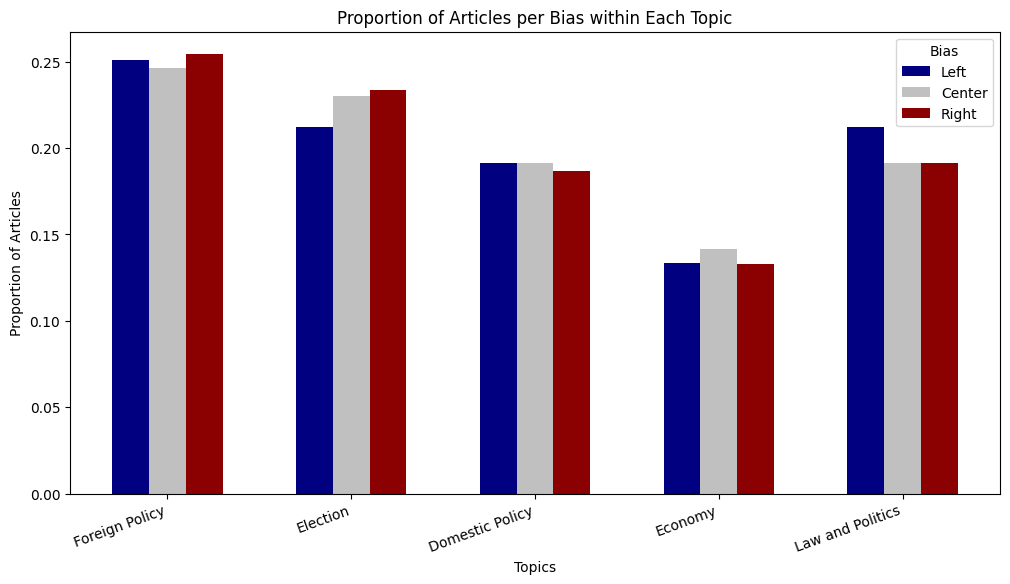

In [58]:
plot_topic_per_bias(topic_per_bias, topic_map)

In [59]:
def plot_bias_per_topic(bias_per_topic, topic_map):
    """
    Plots a stacked bar chart showing the proportion of each bias within each topic,
    with percentage labels inside the bars for readability.

    :param bias_per_topic: Dictionary {topic_id: {bias: proportion}}
    :param topic_map: Dictionary mapping topic_id to topic names
    """
    biases = ['left', 'right', 'center']
    colors = {'left': 'navy', 'right': 'darkred', 'center': 'silver'}
    
    # Extract topic labels in the correct order
    topic_ids = sorted(bias_per_topic.keys())  # Sort topics to maintain order
    topic_labels = [topic_map[t] for t in topic_ids]
    
    # Create data for the stacked bars
    data_matrix = np.array([[bias_per_topic[t][bias] for t in topic_ids] for bias in biases])

    fig, ax = plt.subplots(figsize=(10, 6))

    # Initialize bottom position for stacking bars
    bottom = np.zeros(len(topic_ids))

    # Plot stacked bars
    for i, bias in enumerate(biases):
        bars = ax.bar(topic_labels, data_matrix[i], label=bias.capitalize(), color=colors[bias], bottom=bottom)
        
        # Add text inside bars
        for bar, proportion in zip(bars, data_matrix[i]):
            if proportion > 0.05:  # Only add text if the proportion is large enough
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # Center text in bar
                    bar.get_y() + bar.get_height() / 2,  # Position text at the middle of the section
                    f"{proportion:.0%}",  # Convert proportion to percentage format
                    ha='center', va='center', fontsize=10, color='white', fontweight='bold'
                )
        
        bottom += data_matrix[i]  # Update bottom for next bias

    # Add 33% and 66% lines for reference
    ax.axhline(1/3, color='black', linestyle='--', linewidth=1, label="33% Reference")
    ax.axhline(2/3, color='black', linestyle='--', linewidth=1, label="66% Reference")

    ax.set_ylabel("Proportion of Bias")
    ax.set_xlabel("Topics")
    ax.set_title("Proportion of Bias within Each Topic (Stacked)")
    # Place legend outside the plot
    ax.legend(title="Bias", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

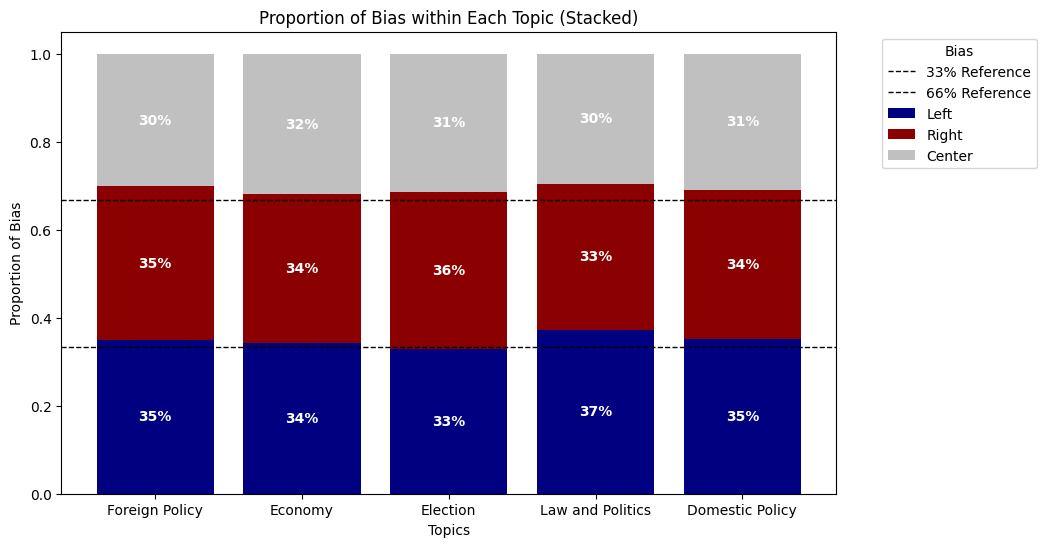

In [62]:
plot_bias_per_topic(bias_per_topic, topic_map)

# Sentiment Analysis

In [60]:
df = df_with_topics[["title", "content", "bias", "article", "topic", "lemmas", "lemmas_no_persons", "top_3_topics", "cleaned_text"]]

For this sentiment analysis section, we will perform multiple analysis :
- Compare polarity and subjectivity sentiments on documents that mentions the candidates (Trump, Biden, Harris)
- Compare sentiments per topic for each bias (left-biased and right-biased)
- Make deeper sentiment analysis using a BERT-based model.

First, we define a function to extract polarity and subjectivity using TextBlob.

In [61]:
from textblob import TextBlob

def get_sentiment(text: str) -> str:
    """
    Computes the sentiment of the given text using TextBlob.
    """
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

#### Sentiment on candidates

Then, we filter our data on the text that include the candidates names.

For this, we define a function that returns 0 or 1 if one the candidate is mentioned in the input text.

In [62]:
def one_hot_encode_candidates(tokens):
    """
    One-hot encodes the presence of candidate names in the token list.
    """
    
    # Standardize candidate names into four main categories
    candidate_map = {
        "Trump": ["trump"],
        "Biden": ["biden"],
        "Harris": ["harris", "kamala"]
    }
    
    # Initialize one-hot encoding dictionary
    one_hot = {"Trump": 0, "Biden": 0, "Harris": 0}
    
    # Check if any candidate name token is in the token list
    for key, aliases in candidate_map.items():
        if any(alias in tokens for alias in aliases):
            one_hot[key] = 1
    
    return one_hot

In [63]:
# Apply the function
df = df.join(df["lemmas"].apply(lambda x: pd.Series(one_hot_encode_candidates(x))))

First, let's see how many articles mentions each candidates

In [64]:
# How much article mention each candidates
df[["Trump", "Biden", "Harris"]].sum()

Trump     529
Biden     157
Harris    242
dtype: int64

In [65]:
# How much candidates are quoted by article
df[["Trump", "Biden", "Harris"]].sum(axis=1).value_counts()

0    568
1    453
2    194
3     29
Name: count, dtype: int64

Now, let's apply sentiment analysis on articles mentioning the candidates (per party).

We will apply sentiment analysis on the articles mentioning Trump only, and compare results on articles mentioning Joe Biden OR Kamala Harris.

In [66]:
# Sentiment analysis
df["trump_sentiment"] = df["content"].apply(lambda x : get_sentiment(x) if (("trump" in x.lower()) and ("harris" not in x.lower()) and ("biden" not in x.lower())) else None)
df["biden_harris_sentiment"] = df["content"].apply(lambda x : get_sentiment(x) if (("biden" in x.lower() or "harris" in x.lower()) and ("trump" not in x.lower())) else None)

##### Left vs Right

Let's compare the results on **polarity** for right-biased and left-biased media with a plot

In [78]:
def plot_sentiment_difference(df, bias_column="bias", trump_column="trump_sentiment", biden_harris_column="biden_harris_sentiment"):
    """
    Plots the difference in sentiment polarity for Trump and Biden/Harris across left, right, and center biases.

    :param df: pandas DataFrame containing sentiment analysis results
    :param bias_column: str, column name containing the bias labels ("left", "right", "center")
    :param trump_column: str, column name containing Trump's sentiment scores (tuple of polarity, subjectivity)
    :param biden_harris_column: str, column name containing Biden/Harris sentiment scores (tuple of polarity, subjectivity)
    """
    # Initialize lists for storing results
    sentiment_data = []

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        bias = row[bias_column]

        # Process Biden/Harris sentiment
        if isinstance(row[biden_harris_column], tuple) and len(row[biden_harris_column]) == 2:
            biden_polarity = row[biden_harris_column][0]  # Extract polarity
            sentiment_data.append({'Candidate': 'Biden/Harris', 'Bias': bias, 'Polarity': biden_polarity})
            
        # Process Trump sentiment
        if isinstance(row[trump_column], tuple) and len(row[trump_column]) == 2:
            trump_polarity = row[trump_column][0]  # Extract polarity
            sentiment_data.append({'Candidate': 'Trump', 'Bias': bias, 'Polarity': trump_polarity})

    # Convert list to DataFrame
    sentiment_df = pd.DataFrame(sentiment_data)


    # Create the bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=sentiment_df, 
        x="Bias", y="Polarity", hue="Candidate", 
        palette={"Biden/Harris": "navy", "Trump": "darkred"},
        dodge=True,
        order=["left", "center", "right"]
    )

    # Add horizontal line at 0 for reference
    plt.axhline(0, color='black', linewidth=1, linestyle="dashed")

    # Labels and title
    plt.ylabel("Mean Sentiment Polarity")
    plt.xlabel("Bias")
    plt.title("Sentiment Polarity for Trump vs. Biden/Harris across Biases")
    plt.ylim(-0.4, 0.4)  # Centering y-axis on 0

    plt.legend(title="Candidate")
    plt.show()

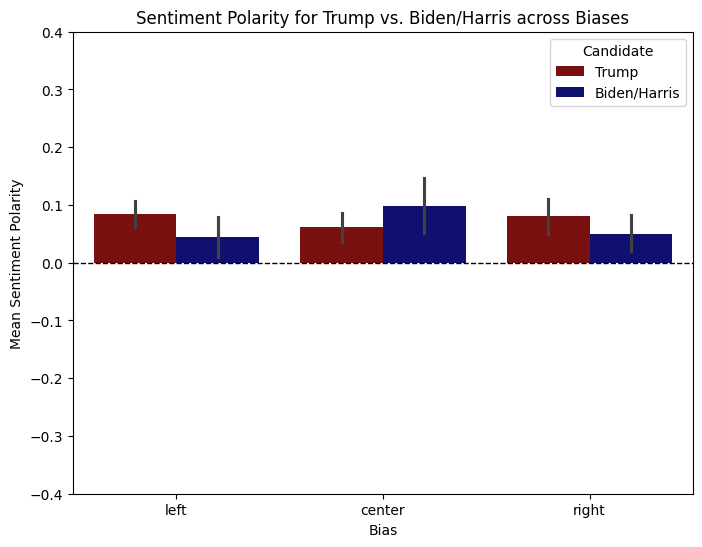

In [80]:
plot_sentiment_difference(df)

From the results, we can see that the difference we could have been expecting is not showing :
- Left-biased media are not more negative when talking about Trump compared to right-biased media. Same for right-biased media with Kamala/Harris.
- Center-biased media have a more positive sentiment towards Harris/Biden then left-biased and right-biased media.

These results are to be mitigated because :
- Donald Trump is mentioned significantly more in the corpus (529 articles) versus Biden or Harris (respectively 157 and 242 articles)
- The pool of newspaper from which the data is derived is stricly selected to be well-known specialised media with a high level of profesionalism. Therefore, the left/right dichotomy is less present in those media than on other media (television, social media...)

----
Now, we define the same plot for subjectity.

In [84]:
def plot_subjectivity_difference(df, bias_column="bias", trump_column="trump_sentiment", biden_harris_column="biden_harris_sentiment"):
    """
    Plots the difference in sentiment subjectivity for Trump and Biden/Harris across left, right, and center biases.

    :param df: pandas DataFrame containing sentiment analysis results
    :param bias_column: str, column name containing the bias labels ("left", "right", "center")
    :param trump_column: str, column name containing Trump's sentiment scores (tuple of polarity, subjectivity)
    :param biden_harris_column: str, column name containing Biden/Harris sentiment scores (tuple of polarity, subjectivity)
    """
    # Initialize lists for storing results
    sentiment_data = []

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        bias = row[bias_column]

        # Process Trump sentiment
        if isinstance(row[trump_column], tuple) and len(row[trump_column]) == 2:
            trump_subjectivity = row[trump_column][1]  # Extract subjectivity
            sentiment_data.append({'Candidate': 'Trump', 'Bias': bias, 'Subjectivity': trump_subjectivity})

        # Process Biden/Harris sentiment
        if isinstance(row[biden_harris_column], tuple) and len(row[biden_harris_column]) == 2:
            biden_subjectivity = row[biden_harris_column][1]  # Extract subjectivity
            sentiment_data.append({'Candidate': 'Biden/Harris', 'Bias': bias, 'Subjectivity': biden_subjectivity})

    # Convert list to DataFrame
    sentiment_df = pd.DataFrame(sentiment_data)

    # Create the bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=sentiment_df, 
        x="Bias", y="Subjectivity", hue="Candidate", 
        palette={"Trump": "darkred", "Biden/Harris": "navy"},
        dodge=True
    )

    # Add horizontal line at 0.5 for reference
    plt.axhline(0.5, color='black', linewidth=1, linestyle="dashed")

    # Labels and title
    plt.ylabel("Mean Sentiment Subjectivity")
    plt.xlabel("Bias")
    plt.title("Sentiment Subjectivity for Trump vs. Biden/Harris across Biases")
    plt.ylim(0, 1)  # Centering y-axis on 0.5

    plt.legend(title="Candidate")
    plt.show()

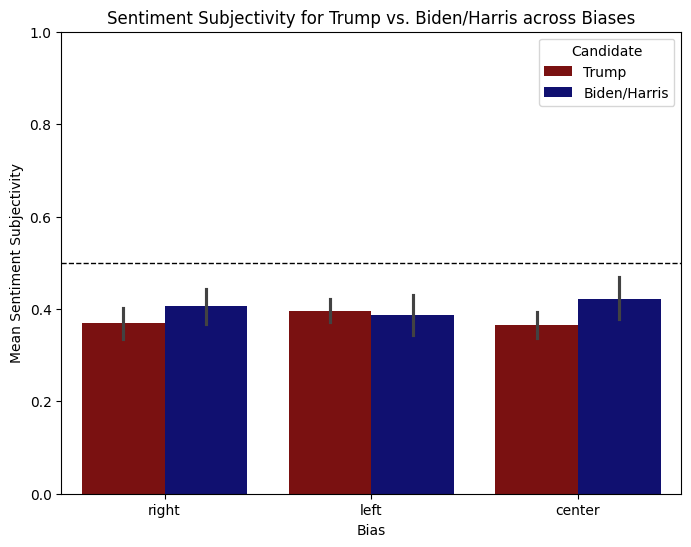

In [85]:
plot_subjectivity_difference(df)

We cannot conclude anything interesting from this plot.

#### Sentiment per topic

First, we compute the sentiment (polarity, subjectivity) for each sample of our corpus.

We will then compare the results for each topic.

In [83]:
df["polarity_score"] = df["content"].apply(lambda x : get_sentiment(x)[0])

In [81]:
def plot_polarity_per_topic(df, topic_column="top_3_topics", polarity_column="polarity_score", bias_column="bias", topic_map=None):
    """
    Plots the mean polarity score for each topic, grouped by left, right, and center bias.

    :param df: pandas DataFrame containing topic modeling and sentiment analysis results
    :param topic_column: str, column name containing the list of top 3 topics [(topic_id, probability)]
    :param polarity_column: str, column name containing the polarity score (-1 to 1)
    :param bias_column: str, column name containing the bias labels ("left", "right", "center")
    :param topic_map: dict, mapping topic IDs to topic names
    """
    if topic_map is None:
        raise ValueError("topic_map must be provided to label topics")

    # Initialize a dictionary to store polarity scores
    topic_polarity_data = []

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        bias = row[bias_column]
        polarity = row[polarity_column]

        # Check if there are valid topics and a polarity score
        if isinstance(row[topic_column], list) and polarity is not None:
            # Assign the polarity to the most probable topic (first in the list)
            main_topic = row[topic_column][0][0]  # Get the most probable topic

            # Append data for visualization
            topic_polarity_data.append({'Topic': topic_map[main_topic], 'Bias': bias, 'Polarity': polarity})

    # Convert list to DataFrame
    topic_polarity_df = pd.DataFrame(topic_polarity_data)

    # Define colors for bias groups
    colors = {'left': 'navy', 'right': 'darkred', 'center': 'silver'}

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=topic_polarity_df, 
        x="Topic", y="Polarity", hue="Bias", 
        palette=colors,
        dodge=True,
        hue_order=["left", "center", "right"]
    )

    # Add horizontal line at 0 for reference
    plt.axhline(0, color='black', linewidth=1, linestyle="dashed")

    # Labels and title
    plt.ylabel("Mean Polarity Score")
    plt.xlabel("Topics")
    plt.title("Mean Polarity Score per Topic, grouped by Bias")
    plt.ylim(-0.2, 0.2)  # Centering y-axis on 0

    plt.legend(title="Bias")
    plt.xticks(rotation=20, ha='right')
    plt.show()

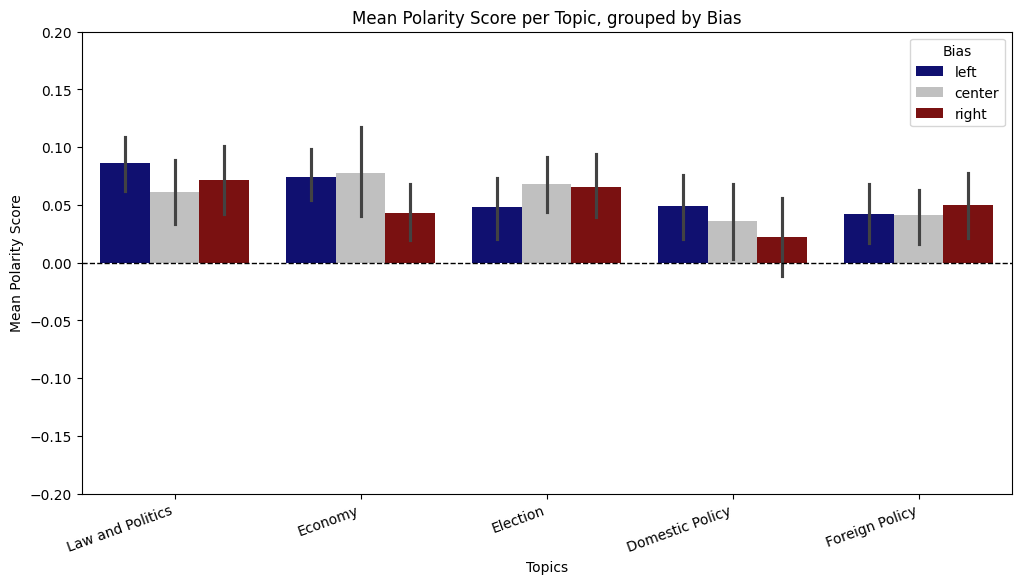

In [86]:
plot_polarity_per_topic(df, topic_map=topic_map)

Here, we shall note that we used scaling to our advantage. The polarity score range is [-1, 1] but we defined a scale of [-0.2, 0.2] to make small changes appear bigger.

However, we can see slightly interesting results :

**Economy**: 
- Suprisingly, right-biased media is less positive about economy then left-biased media.
- It could be explained by the fact that at the time of the articles, the Democrate party was in power.

**Domestic Policies**
- Also, we see that there is absolutely no polarity score below 0 on domestic policies for left-biased media.
- We see that right-biased media expressed some negativity on domestic policies.

**Foreign Policies** :
- Less suprisingly (given the foreign policies topics at the time : Israel-Gaza, Ukraine-Russia...), the left-biased media are less positive than right-biased media on these topics.
- We can see that the minimum scores for the left-biased media is negative, while the minimum is around 0 for both right-biased and center-biased articles.



## Advanced sentiment analysis

##### Economy & FinBert

In order to be more specific on the economical article analysis, we will use FinBERT to classify the economical data as positive, neutral or negative.

In [77]:
# Load the pre-trained finBERT model

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Device set to use mps:0


In [78]:
# Extract the subset of economical articles

# Add a boolean economy column to the dataframe
df["economy"] = df["top_3_topics"].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 and x[0][0] == 3 else 0)

# Select only the economy articles
economy_df = df[df["economy"] == 1]

# Apply the sentiment analysis model to the economy articles
economy_df["finbert_sentiment"] = economy_df["content"].apply(lambda x: nlp(x)[0]["label"])

/var/folders/60/dhk32zz121zcg97k0qp8m6z40000gn/T/ipykernel_96516/2798398321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economy_df["finbert_sentiment"] = economy_df["content"].apply(lambda x: nlp(x)[0]["label"])


In [79]:
# Group by bias and count the sentiment labels
sentiment_counts = economy_df.groupby(["bias", "finbert_sentiment"]).size().unstack()

sentiment_counts

finbert_sentiment,Negative,Neutral,Positive
bias,,,
center,15,50,8
left,22,63,7
right,14,63,5


##### BERT-based polarity

In order to test other methods, we will try comparing polarity again. This time, polarity is computed using a BERT-based model.

We will categorize articles as neutral, positive or negative.

We will compare the number of positive and negative articles per topic per bias.

In [80]:
import torch
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def compute_sentiment(text: str, tokenizer=tokenizer, model=model):
    """
    Compute sentiment based on the input text using a pre-trained model.
    """
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", max_length=800, truncation=True)

    # Perform the forward pass
    outputs = model(**inputs)
    
    # Get the predicted class
    predicted_class = torch.argmax(outputs.logits).item()
    
    # Map the predicted class to a sentiment label
    sentiment = "positive" if predicted_class == 2 else "neutral" if predicted_class == 1 else "negative"
    
    return sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
df["bert_sentiment"] = df["content"].apply(compute_sentiment)

In [82]:
def plot_bert_sentiment_per_topic(df, topic_column="top_3_topics", sentiment_column="bert_sentiment", bias_column="bias", topic_map=None):
    """
    Plots the count of positive and negative sentiment articles per topic, grouped by left and right bias.
    Also includes a bar for the total number of articles per topic.

    :param df: pandas DataFrame containing topic modeling and sentiment analysis results
    :param topic_column: str, column name containing the list of top 3 topics [(topic_id, probability)]
    :param sentiment_column: str, column name containing the BERT sentiment output ("negative", "positive", "neutral")
    :param bias_column: str, column name containing the bias labels ("left", "right", "center")
    :param topic_map: dict, mapping topic IDs to topic names
    """
    if topic_map is None:
        raise ValueError("topic_map must be provided to label topics")

    # Initialize a dictionary to count positive and negative sentiment occurrences
    topic_sentiment_counts = {topic_map[t]: {"positive_left": 0, "positive_right": 0, "negative_left": 0, "negative_right": 0, "total_articles": 0}
                              for t in topic_map.keys()}

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        if isinstance(row[topic_column], list):
            main_topic = row[topic_column][0][0]  # Get the most probable topic
            topic_name = topic_map[main_topic]
            bias = row[bias_column]
            sentiment = row[sentiment_column]

            # Count sentiment occurrences by bias
            if sentiment == "positive":
                if bias == "left":
                    topic_sentiment_counts[topic_name]["positive_left"] += 1
                elif bias == "right":
                    topic_sentiment_counts[topic_name]["positive_right"] += 1
            elif sentiment == "negative":
                if bias == "left":
                    topic_sentiment_counts[topic_name]["negative_left"] -= 1
                elif bias == "right":
                    topic_sentiment_counts[topic_name]["negative_right"] -= 1

            # Count total articles per topic
            topic_sentiment_counts[topic_name]["total_articles"] += 1

    # Convert to DataFrame for visualization
    topic_sentiment_df = pd.DataFrame.from_dict(topic_sentiment_counts, orient='index').reset_index()
    topic_sentiment_df = topic_sentiment_df.rename(columns={'index': 'Topic'})

    # Plot the bars
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(topic_sentiment_df["Topic"]))  # Topic positions
    bar_width = 0.2  # Width of bars

    # Plot positive and negative sentiments
    ax.bar(x - bar_width, topic_sentiment_df["positive_left"], width=bar_width, color="navy", label="Left")
    ax.bar(x, topic_sentiment_df["positive_right"], width=bar_width, color="darkred", label="Right")
    ax.bar(x + bar_width, topic_sentiment_df["negative_right"], width=bar_width, color="darkred", label="Right")
    ax.bar(x + 2*bar_width, topic_sentiment_df["negative_left"], width=bar_width, color="navy", label="Left")

    # Formatting
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(topic_sentiment_df["Topic"], rotation=20, ha="right")
    ax.axhline(0, color='black', linewidth=1, linestyle="dashed")

    ax.set_ylabel("Count of Articles")
    ax.set_xlabel("Topics")
    ax.set_title("Sentiment Analysis (BERT) per Topic, grouped by Bias")

    ax.legend(title="Sentiment")
    plt.show()

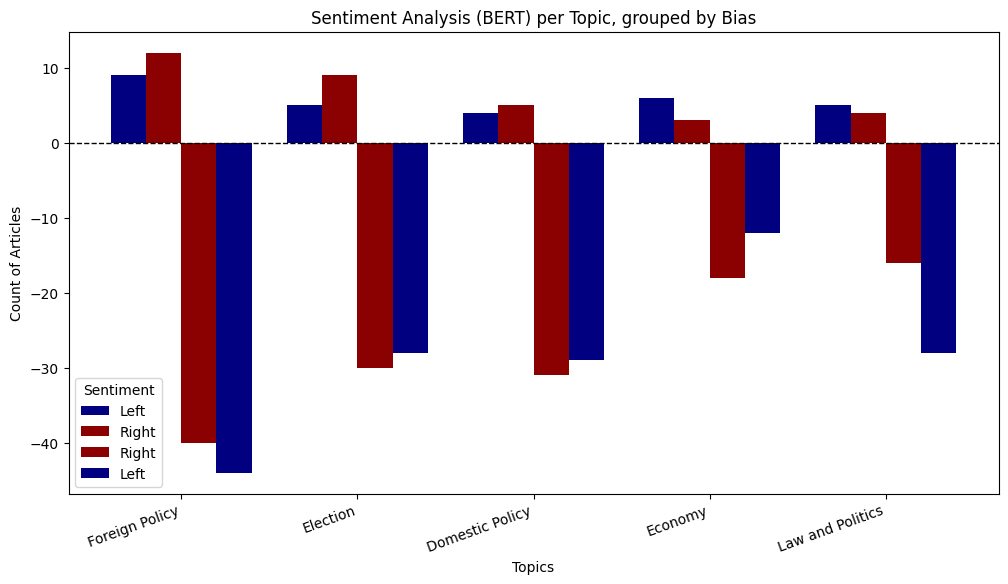

In [83]:
plot_bert_sentiment_per_topic(df, topic_map=topic_map)

# Bonus : Scrapping scripts

In order to run these scripts, chromedriver must be downloaded and the driver must be placed in the same directory as this notebook.

This first cell defines the dates on which we want to scrape the data

In [ ]:
import time, datetime, random
import numpy as np

# Generate dates with format yyyy-mm-dd from start_date to end_date
def generate_dates(start_date, end_date):
    dates = []
    start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
    for date in date_generated:
        dates.append(date.strftime("%Y-%m-%d"))
    return dates

# Generate date 
start_date = "2024-12-30"
end_date = "2024-12-31"

dates_to_scrape = generate_dates(start_date, end_date)

This second cell scraps the links of the articles for the given dates.

For topic selection, the topic variable must be modified to a valid AllSides topic.

In [ ]:
import time, sys
import pickle
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

# Add Chromedriver directory to system PATH
sys.path.append(r"driver/chromedriver")

# Settings
wait_time = 0.5  # Adjust wait time if needed

dates_to_scrape = dates_to_scrape
base_url = "https://www.allsides.com/headline-roundups"
topic = "Immigration"

# Set up ChromeDriver
chromedriver_path = r"driver/chromedriver"
serv = Service(chromedriver_path)
chrome_options = Options()

driver = webdriver.Chrome(service=serv, options=chrome_options)

def check_website_access():
    try:
        driver.get(base_url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        print("Successfully accessed the website.")
    except Exception as e:
        print(f"Failed to access the website: {e}")
        driver.quit()
        exit()

check_website_access()

# Handle cookies panel if it exists
try:
    cookie_button = WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "css-47sehv"))
    )
    cookie_button.click()
    print("Accepted cookies policy.")
except:
    print("No cookies panel detected.")

links = []

for target_date in dates_to_scrape:
    print(f"Scraping links for {target_date}...")
    driver.get(base_url)
    wait = WebDriverWait(driver, 10)
    
    # Select the date input field and enter the target date
    date_input = wait.until(
        EC.presence_of_element_located((By.ID, "edit-field-story-date-value-value-datepicker-popup-0"))
    )
    date_input.clear()
    date_input.send_keys(target_date)
    
    # Choose a topic
    # Select the "2024 Presidential Election" topic
    topic_dropdown = wait.until(
        EC.presence_of_element_located((By.ID, "edit-field-story-topic-tid"))
    )
    topic_dropdown.send_keys(topic)
    
    # Click the Apply button to filter results by date
    apply_button = driver.find_element(By.ID, "edit-submit-allsides-story-topic-list")
    apply_button.click()
    time.sleep(3)  # Allow results to load
    
    # Get last page index (limit to first 30 pages)
    last_page_index = min(0, 1)  # Only scrape first 30 pages
    
    # Loop through pages
    for page in range(0, last_page_index + 1):
        driver.get(f"{base_url}?field_story_date_value%5Bvalue%5D%5Bdate%5D={target_date}&page={page}")
        time.sleep(0.5)
        
        articles = driver.find_elements(By.CSS_SELECTOR, "td.views-field.views-field-name a")
        
        for article in articles:
            links.append(article.get_attribute("href"))
        
        print(f"Page {page} - Collected {len(links)} links so far.")
        time.sleep(5)

# Close the browser
driver.quit()

# Save links
with open("article_links.pickle", "wb") as f:
    pickle.dump(links, f, pickle.HIGHEST_PROTOCOL)

with open("article_links.csv", "w") as f:
    for link in links:
        f.write(link + "\n")

print(f"Scraping completed. {len(links)} links collected.")

The next cell defines a function to scrap content from a valid AllSides link.

In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

def scrape_article(url):
    chrome_options = Options()
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    
    service = Service("driver/chromedriver-mac-arm64/chromedriver")  # Adjust path if needed
    driver = webdriver.Chrome(service=service, options=chrome_options)
    
    driver.get(url)
    time.sleep(5)  # Give JavaScript time to load content
    
    WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
    
    # Extract neutral title
    try:
        title_element = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'taxonomy-heading'))
        )
        title = title_element.text.strip()
    except:
        title = "Title not found"
    
    # Extract article titles from left, center, and right
    articles = []
    
    biases = {"right": "right", "center": "center", "left": "left"}
    
    for bias_class, bias_label in biases.items():
        try:
            article_div = driver.find_element(By.CLASS_NAME, f'{bias_class}')
            article_link = article_div.find_element(By.CLASS_NAME, 'news-title')
            article_title = article_link.text.strip()
            
            try:
                body_content_element = article_div.find_element(By.CLASS_NAME, 'body-contents')
                article_content = body_content_element.text
            except:
                print(f"No body content found for {bias_label} bias.")
            
            articles.append({
                "bias": bias_label,
                "title": article_title,
                "content": article_content
            })
        except:
            print(f"No article found for {bias_label} bias.")
    
    driver.quit()
    
    return {"title": title, "articles": articles}

This last cell loops through the links to retrieve the articles content.

In [ ]:
import pandas as pd
import random
import time
import pickle


# Load links
with open(f"article_links.pickle", "rb") as f:
    links = pickle.load(f)
    
links = set(links)

# Scrape articles
df = pd.DataFrame(columns=["title", "bias", "article"])
results = []

time.sleep(10)

count = 0

for link in links:
    result = scrape_article(link)
    results.append(result)
    
    # Save results to CSV
    
    result_df = pd.DataFrame(
        [{'title': result['title'], 'bias': article['bias'], 'content': article["content"], 'article': article['title']} 
         for article in result['articles']])
    
    count += result_df.shape[0]
    
    df = pd.concat([df, result_df], ignore_index=True)
    
    
    # Save to csv every 10 articles
    if count > 50:
    
        df.to_csv(f"articles.csv", index=False)
    
        print(f"Saved {len(df)} articles to CSV.")
    
        count = 0
    
    
    # Sleep for a random duration
    sleep_duration = random.uniform(1, 5)
    time.sleep(sleep_duration)


df.to_csv(f"articles.csv", index=False)